In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append("../src")
from io_utils import load_pkl, save_csv, save_pkl, save_fig, save_model, load_model

## 1) Loading the cleaned data 
- data was saved from Fraud_DetectionV2.ipynb and exists in the Data/processed folder
- Loading via .pkl file for drop-in exact Python object

In [2]:
df = load_pkl("df_cleaned.pkl")
print(f"Loaded df_cleaned.pkl with shape: {df.shape}")
print(f"Columns ({len(df.columns)}): {list(df.columns)}\n")

Loaded df_cleaned.pkl with shape: (198000, 19)
Columns (19): ['gender', 'age', 'state', 'city', 'account_type', 'transaction_amount', 'transaction_type', 'merchant_category', 'account_balance', 'transaction_device', 'is_fraud', 'transaction_description', 'flag_txnloc_missing', 'flag_geo_mismatch', 'txn_to_balance_ratio_log', 'dow_sin', 'dow_cos', 'hour_sin', 'hour_cos']



## 2) Splitting the data
- creating a holdout split

In [3]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the split
print(f"   X_train size: {X_train.shape}, X_test size: {X_test.shape}")

# Check distribution of the target variable
print("Target distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nTarget distribution in testing set:")
print(y_test.value_counts(normalize=True))

   X_train size: (158400, 18), X_test size: (39600, 18)
Target distribution in training set:
is_fraud
0    0.919318
1    0.080682
Name: proportion, dtype: float64

Target distribution in testing set:
is_fraud
0    0.919318
1    0.080682
Name: proportion, dtype: float64


## 3) Identifying categorical features for encoding 

In [4]:
# Identify the categorical columns
categorical_cols = X_train.select_dtypes(
    include=["object", "category"]
).columns.tolist()
print("Categorical columns:", categorical_cols)

# Identifying the numerical columns here as well prior to one-hot encoding
numeric_cols = X_train.select_dtypes(include="number").columns.tolist()

Categorical columns: ['gender', 'state', 'city', 'account_type', 'transaction_type', 'merchant_category', 'transaction_device', 'transaction_description']


In [5]:
# Figure out which categorical columns are nominal --> dropping transaction_type, transaction_device, and transaction_description
# from this list to save them for target encoding later (based on EDA findings)
nominal_cols = ["gender", "account_type", "merchant_category", "city", "state"]

In [6]:
# checking for high cardinality in nominal columns
threshold = 35
one_hot_cols = [col for col in nominal_cols if X_train[col].nunique() <= threshold]
high_card_cols = [col for col in nominal_cols if X_train[col].nunique() > threshold]

print("One-hot encode these (train-fit):", one_hot_cols)
print(
    "High-cardinality (freq encode):", {c: X_train[c].nunique() for c in high_card_cols}
)

One-hot encode these (train-fit): ['gender', 'account_type', 'merchant_category', 'state']
High-cardinality (freq encode): {'city': 146}


## 4) One-hot encode (encode on *train*, apply to *test*)

In [7]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

ohe_train = ohe.fit_transform(X_train[one_hot_cols])
ohe_cols_out = ohe.get_feature_names_out(one_hot_cols)
ohe_train = pd.DataFrame(ohe_train, columns=ohe_cols_out, index=X_train.index)

ohe_test = ohe.transform(X_test[one_hot_cols])
ohe_test = pd.DataFrame(ohe_test, columns=ohe_cols_out, index=X_test.index)

X_train = pd.concat([X_train.drop(columns=one_hot_cols), ohe_train], axis=1)
X_test = pd.concat([X_test.drop(columns=one_hot_cols), ohe_test], axis=1)

## 5) Frequency encode high cardinality columns (on train, applied to test)

In [8]:
for col in high_card_cols:
    if col in X_train.columns:
        counts = X_train[col].value_counts()
        X_train[col + "_freq"] = X_train[col].map(counts).fillna(0).astype(int)
        X_test[col + "_freq"] = X_test[col].map(counts).fillna(0).astype(int)

        # Drop the raw high-cardinality column
        X_train.drop(columns=[col], inplace=True)
        X_test.drop(columns=[col], inplace=True)

## 6) Normalization of numeric columns (on train, applied to test)

Normalizing the numeric feature columns so that they are on a consistent scale.  
- Target column (`is_fraud`) is excluded.  
- Numeric features: `age`, `transaction_amount`, `account_balance`, `city_freq` , `txn_to_balance_ratio_log`

In [9]:
# list numeric columns PLUS our new frequency encoded columns
numeric_cols = numeric_cols + [
    col + "_freq" for col in high_card_cols if col in X_train.columns
]
print("Numeric columns:", numeric_cols)

Numeric columns: ['age', 'transaction_amount', 'account_balance', 'flag_txnloc_missing', 'flag_geo_mismatch', 'txn_to_balance_ratio_log', 'dow_sin', 'dow_cos', 'hour_sin', 'hour_cos']


In [10]:
# Keep only numeric feature columns needing scaling
features_to_normalize = [
    "age",
    "transaction_amount",
    "account_balance",
    "txn_to_balance_ratio_log",
    "city_freq",
]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train[features_to_normalize])
X_train[[c + "_scaled" for c in features_to_normalize]] = scaler.transform(
    X_train[features_to_normalize]
)
X_test[[c + "_scaled" for c in features_to_normalize]] = scaler.transform(
    X_test[features_to_normalize]
)

# dropping non-scalled columns
X_train.drop(columns=features_to_normalize, inplace=True, errors="ignore")
X_test.drop(columns=features_to_normalize, inplace=True, errors="ignore")

## 7) Engineering features related to the target (on train, applied to test)
- engineering features based on exploratory analysis (see plots) for:
    - fraud rate per transaction_decvice
    - fraud rate per transaction_type
    - fraud rate per transaction_description

In [11]:
# creating a reuseable function for target encoding
def target_encode(train_X, train_y, test_X, col, target="is_fraud", drop_raw=True):
    """
    Create a target-encoded feature from one categorical column.
    Fits on train only, applies to train and test.
    """
    # Build a temp frame for grouping
    tmp = pd.DataFrame({col: train_X[col], target: train_y})

    # Fraud rate per category
    mapping = tmp.groupby(col)[target].mean().to_dict()

    # Backoff = global fraud rate (for unseen categories in test)
    global_rate = train_y.mean()

    # Map into new columns
    train_X[f"{col}_fraud_rate"] = train_X[col].map(mapping).fillna(global_rate)
    test_X[f"{col}_fraud_rate"] = test_X[col].map(mapping).fillna(global_rate)

    # Drop the original col - default = True
    if drop_raw:
        train_X.drop(columns=[col], inplace=True)
        test_X.drop(columns=[col], inplace=True)

    return mapping

In [12]:
# transaction_device
device_mapping = target_encode(X_train, y_train, X_test, "transaction_device")
print("\nFraud rate by transaction_device:")
for k, v in device_mapping.items():
    print(f"{k}: {v:.4f}")

# transaction_type
type_mapping = target_encode(X_train, y_train, X_test, "transaction_type")
print("\nFraud rate by transaction_type:")
for k, v in type_mapping.items():
    print(f"{k}: {v:.4f}")

# transaction_description
desc_mapping = target_encode(X_train, y_train, X_test, "transaction_description")
print("\nTop 10 fraud rates by transaction_description:")
for k, v in sorted(desc_mapping.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{k}: {v:.4f}")


Fraud rate by transaction_device:
ATM: 0.0370
ATM Booth Kiosk: 0.0341
Bank Branch: 0.0315
Banking Chatbot: 0.0321
Biometric Scanner: 0.1101
Debit/Credit Card: 0.1775
Desktop/Laptop: 0.0338
Mobile Device: 0.0351
POS Mobile App: 0.1046
POS Mobile Device: 0.1015
POS Terminal: 0.0339
Payment Gateway Device: 0.1735
QR Code Scanner: 0.1771
Self-service Banking Machine: 0.0364
Smart Card: 0.0379
Tablet: 0.0367
Virtual Card: 0.1753
Voice Assistant: 0.1758
Wearable Device: 0.1117
Web Browser: 0.1772

Fraud rate by transaction_type:
Bill Payment: 0.0901
Credit: 0.0942
Debit: 0.0913
Transfer: 0.0912
Withdrawal: 0.0362

Top 10 fraud rates by transaction_description:
bitcoin_transaction: 1.0000
online_purchase: 1.0000
Car service: 0.0591
Childcare expense: 0.0571
Streaming service subscription: 0.0568
Debt repayment: 0.0567
Political donation: 0.0549
Membership subscription: 0.0549
Import duty payment: 0.0544
Monthly installment: 0.0541


In [13]:
# Check remaining columns
print("Remaining columns in the encoded dataset:")
print(X_train.columns)

Remaining columns in the encoded dataset:
Index(['flag_txnloc_missing', 'flag_geo_mismatch', 'dow_sin', 'dow_cos',
       'hour_sin', 'hour_cos', 'gender_Male', 'account_type_Checking',
       'account_type_Savings', 'merchant_category_Electronics',
       'merchant_category_Entertainment', 'merchant_category_Groceries',
       'merchant_category_Health', 'merchant_category_Restaurant',
       'state_Andhra Pradesh', 'state_Arunachal Pradesh', 'state_Assam',
       'state_Bihar', 'state_Chandigarh', 'state_Chhattisgarh',
       'state_Dadra and Nagar Haveli and Daman and Diu', 'state_Delhi',
       'state_Goa', 'state_Gujarat', 'state_Haryana', 'state_Himachal Pradesh',
       'state_Jharkhand', 'state_Karnataka', 'state_Kerala',
       'state_Lakshadweep', 'state_Madhya Pradesh', 'state_Maharashtra',
       'state_Manipur', 'state_Meghalaya', 'state_Mizoram', 'state_Nagaland',
       'state_Odisha', 'state_Puducherry', 'state_Punjab', 'state_Rajasthan',
       'state_Sikkim', 'state_T

In [14]:
# quick sanity check to make sure X_train and X_test have the same columns
if set(X_train.columns) == set(X_test.columns):
    print("X_train and X_test have the same columns.")
else:
    print("Column mismatch between X_train and X_test!")

# one last assertion to ensure all columns are numeric for modelling
assert all(
    np.issubdtype(dtype, np.number) for dtype in X_train.dtypes
), "Not all columns in X_train are numeric"
assert all(
    np.issubdtype(dtype, np.number) for dtype in X_test.dtypes
), "Not all columns in X_test are numeric"

X_train and X_test have the same columns.


## 8) Setting up a Cross-Validation object to use on the training data 

In [15]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 9) Comparing models
- using ROC_AUC scoring for imbalanced classification (see exploratory fraud distribution plot)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

model_grids = []  # We will keep trained models here to print the result easier

# kNN
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(
    knn,
    param_grid={"n_neighbors": [3, 5, 7, 11, 21]},
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
)
knn_grid.fit(X_train, y_train)
model_grids.append(knn_grid)

# Logistic Regression (Logistic baseline/sanity check, weighted for imbalance)
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr_grid = GridSearchCV(
    lr, param_grid={"C": [0.1, 1, 10]}, scoring="roc_auc", cv=cv, n_jobs=-1
)
lr_grid.fit(X_train, y_train)
model_grids.append(lr_grid)

# Decision Tree (simple interpretable baseline)
dt = DecisionTreeClassifier(class_weight="balanced", random_state=42)
dt_grid = GridSearchCV(
    dt,
    param_grid={"max_depth": [None, 6, 10, 20], "min_samples_leaf": [1, 2, 5, 10]},
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
)
dt_grid.fit(X_train, y_train)
model_grids.append(dt_grid)

# Random Forest
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_grid = GridSearchCV(
    rf,
    {"max_depth": [None, 10, 20], "n_estimators": [200, 400]},
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
)
rf_grid.fit(X_train, y_train)
model_grids.append(rf_grid)

In [17]:
for model in model_grids:
    print(model.best_estimator_, "– roc_auc:", model.best_score_)

KNeighborsClassifier(n_neighbors=21) – roc_auc: 0.7959125330275231
LogisticRegression(C=10, class_weight='balanced', max_iter=1000) – roc_auc: 0.8899886116436138
DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=42) – roc_auc: 0.8891923777860743
RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=400,
                       random_state=42) – roc_auc: 0.8885693362512974


## 10) Saving model_grids to a .pkl file

In [18]:
save_pkl(model_grids, "cv_model_grids.pkl")
print("All models saved to cv_model_grids.pkl")

Pickle saved: /Users/emilyoor/Documents/Code/Portfolio_Project1_financialtransactions/Data/processed/cv_model_grids.pkl
All models saved to cv_model_grids.pkl


## 11) Evaluate which model(s) should be used on the training set 
- cv confirmed 3 models performed similarly (LR, DT and RF)
- will compare only these models going forward, dropping KNN 

In [19]:
# For Logistic Regression
# Grab the index of the best parameter setting
best_idx = lr_grid.best_index_

# Get fold-by-fold scores for that setting
lr_fold_scores = (
    lr_grid.cv_results_["split0_test_score"][best_idx],
    lr_grid.cv_results_["split1_test_score"][best_idx],
    lr_grid.cv_results_["split2_test_score"][best_idx],
    lr_grid.cv_results_["split3_test_score"][best_idx],
    lr_grid.cv_results_["split4_test_score"][best_idx],
)

lr_fold_scores = np.array(lr_fold_scores)

In [20]:
# For Decision Tree
# Grab the index of the best parameter setting
best_idx = dt_grid.best_index_

# Get fold-by-fold scores for that setting
dt_fold_scores = (
    dt_grid.cv_results_["split0_test_score"][best_idx],
    dt_grid.cv_results_["split1_test_score"][best_idx],
    dt_grid.cv_results_["split2_test_score"][best_idx],
    dt_grid.cv_results_["split3_test_score"][best_idx],
    dt_grid.cv_results_["split4_test_score"][best_idx],
)

dt_fold_scores = np.array(dt_fold_scores)

In [21]:
# For Random Forest
# Grab the index of the best parameter setting
best_idx = rf_grid.best_index_

# Get fold-by-fold scores for that setting
rf_fold_scores = (
    rf_grid.cv_results_["split0_test_score"][best_idx],
    rf_grid.cv_results_["split1_test_score"][best_idx],
    rf_grid.cv_results_["split2_test_score"][best_idx],
    rf_grid.cv_results_["split3_test_score"][best_idx],
    rf_grid.cv_results_["split4_test_score"][best_idx],
)

rf_fold_scores = np.array(rf_fold_scores)

In [22]:
# Using Friedman test to check if there is any significant difference between the models overall
from scipy.stats import friedmanchisquare

stat, p_val = friedmanchisquare(lr_fold_scores, dt_fold_scores, rf_fold_scores)
print("Friedman test p-value:", p_val)

Friedman test p-value: 0.0742735782143338


no model is significanty better than the others

/var/folders/b7/12lnbcrn46q_2m06cl7v_25w0000gn/T/ipykernel_30145/2247807444.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


Figure saved: /Users/emilyoor/Documents/Code/Portfolio_Project1_financialtransactions/Reports/figures/model_cv_roc_auc_comparison.png


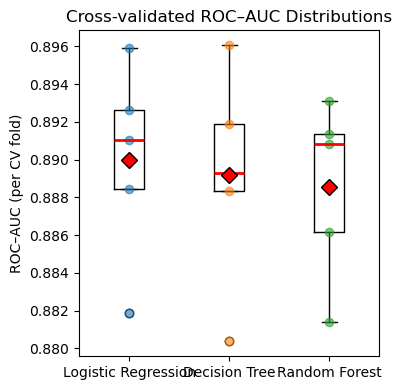

In [23]:
# Collect into list
scores = [lr_fold_scores, dt_fold_scores, rf_fold_scores]
labels = ["Logistic Regression", "Decision Tree", "Random Forest"]

plt.figure(figsize=(4, 4))
bp = plt.boxplot(
    scores,
    labels=labels,
    showmeans=True,
    meanprops={
        "marker": "D",  # diamond instead of triangle
        "markerfacecolor": "red",  # fill color
        "markeredgecolor": "black",  # outline color
        "markersize": 8,
    },
    medianprops={"color": "red", "linewidth": 2},
)

for i, y in enumerate(scores, start=1):
    plt.plot([i] * len(y), y, "o", alpha=0.6)

plt.ylabel("ROC–AUC (per CV fold)")
plt.title("Cross-validated ROC–AUC Distributions")
plt.tight_layout()
plt.draw()
save_fig(plt, "model_cv_roc_auc_comparison.png")

## 12) Building fresh models with the best hyperparameters from the cross validations 

In [24]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)

best_lr = LogisticRegression(
    max_iter=1000, class_weight="balanced", **lr_grid.best_params_
)
best_dt = DecisionTreeClassifier(
    class_weight="balanced", random_state=42, **dt_grid.best_params_
)
best_rf = RandomForestClassifier(
    class_weight="balanced", random_state=42, **rf_grid.best_params_
)

# make a list to collect metrics
results = []
predictions = {}  # to store predictions for later plots

models = [
    ("Logistic Regression", best_lr),
    ("Decision Tree", best_dt),
    ("Random Forest", best_rf),
]

# Fit on the FULL training set and evaluate on the TEST set
for name, model in models:
    model.fit(X_train, y_train)

    # Save the trained model
    filename = name.lower().replace(" ", "_") + ".pkl"
    save_model(model, filename)

    # Use probabilities for ROC–AUC; use a 0.5 threshold for class labels
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Save predictions for later plots
    predictions[name] = {"proba": y_proba, "pred": y_pred}

    auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n{name}")
    print(f"Test ROC–AUC: {auc:.4f} | Test Accuracy: {acc:.4f}")
    print("Classification report:\n", classification_report(y_test, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    # collect into results list
    results.append(
        {
            "Model": name,
            "ROC–AUC": round(auc, 3),
            "PR–AUC": round(pr_auc, 3),
            "Accuracy": round(acc, 3),
            "Precision": round(prec, 3),
            "Recall": round(rec, 3),
            "F1": round(f1, 3),
        }
    )

Model saved: /Users/emilyoor/Documents/Code/Portfolio_Project1_financialtransactions/Models/logistic_regression.pkl

Logistic Regression
Test ROC–AUC: 0.8877 | Test Accuracy: 0.8954
Classification report:
               precision    recall  f1-score   support

           0      0.972     0.912     0.941     36405
           1      0.413     0.706     0.521      3195

    accuracy                          0.895     39600
   macro avg      0.693     0.809     0.731     39600
weighted avg      0.927     0.895     0.907     39600

Confusion matrix:
 [[33201  3204]
 [  940  2255]]


Exception ignored in: <function ResourceTracker.__del__ at 0x107a3db20>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Model saved: /Users/emilyoor/Documents/Code/Portfolio_Project1_financialtransactions/Models/decision_tree.pkl

Decision Tree
Test ROC–AUC: 0.8872 | Test Accuracy: 0.9043
Classification report:
               precision    recall  f1-score   support

           0      0.972     0.923     0.947     36405
           1      0.441     0.694     0.539      3195

    accuracy                          0.904     39600
   macro avg      0.706     0.808     0.743     39600
weighted avg      0.929     0.904     0.914     39600

Confusion matrix:
 [[33592  2813]
 [  978  2217]]


Exception ignored in: <function ResourceTracker.__del__ at 0x1102a1b20>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102489b20>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105e31b20>
Traceback (most recent call last

Model saved: /Users/emilyoor/Documents/Code/Portfolio_Project1_financialtransactions/Models/random_forest.pkl

Random Forest
Test ROC–AUC: 0.8869 | Test Accuracy: 0.9637
Classification report:
               precision    recall  f1-score   support

           0      0.968     0.993     0.981     36405
           1      0.886     0.631     0.737      3195

    accuracy                          0.964     39600
   macro avg      0.927     0.812     0.859     39600
weighted avg      0.962     0.964     0.961     39600

Confusion matrix:
 [[36146   259]
 [ 1178  2017]]


In [25]:
# creating output table
df_results = pd.DataFrame(results)

# show as markdown (to prepare for reports)
print(df_results.to_markdown(index=False))

| Model               |   ROC–AUC |   PR–AUC |   Accuracy |   Precision |   Recall |    F1 |
|:--------------------|----------:|---------:|-----------:|------------:|---------:|------:|
| Logistic Regression |     0.888 |    0.737 |      0.895 |       0.413 |    0.706 | 0.521 |
| Decision Tree       |     0.887 |    0.715 |      0.904 |       0.441 |    0.694 | 0.539 |
| Random Forest       |     0.887 |    0.737 |      0.964 |       0.886 |    0.631 | 0.737 |


## 13) Creating a plot to show the top feature importances in each model

Figure saved: /Users/emilyoor/Documents/Code/Portfolio_Project1_financialtransactions/Reports/figures/TopFeatures.png


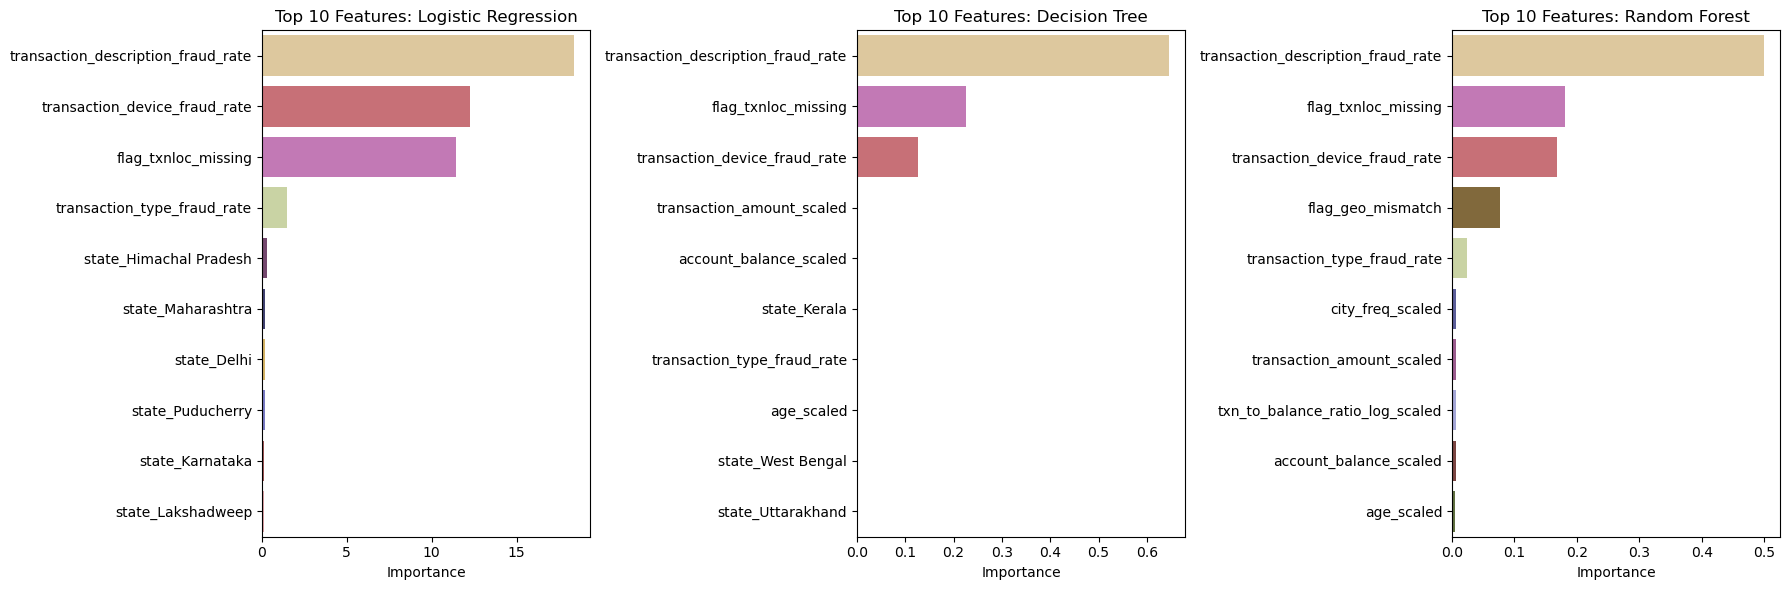

In [26]:
n_features = X_train.shape[1]
feature_names = list(X_train.columns)

# gather top-10 features from each model ---
top_feats = {}
top_imps = {}
all_top = []

for name, model in models:
    if hasattr(model, "coef_"):
        importances = np.abs(model.coef_[0])
    elif hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        continue

    idx = np.argsort(importances)[::-1][:10]
    feats = [feature_names[i] for i in idx]
    imps = importances[idx]

    top_feats[name] = feats
    top_imps[name] = imps
    all_top.extend(feats)

# assign each feature a unique color
unique_feats = list(set(all_top))
palette = sns.color_palette("tab20b", len(unique_feats))
feature_color_map = {f: palette[i] for i, f in enumerate(unique_feats)}

# make one figure with subplots
n_models = len(top_feats)
fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 6), sharex=False)

if n_models == 1:
    axes = [axes]  # keep iterable

for ax, (name, feats) in zip(axes, top_feats.items()):
    imps = top_imps[name]
    colors = [feature_color_map[f] for f in feats]

    sns.barplot(x=imps, y=feats, hue=colors, ax=ax, palette=colors, legend=False)
    ax.set_title(f"Top 10 Features: {name}")
    ax.set_xlabel("Importance")
    ax.set_ylabel("")

plt.tight_layout()
plt.draw()
save_fig(plt, "TopFeatures.png")

## 14) Defining the best classifier overall as the Random Forest 
due to higher accuracy, precision, and F1
- report plots for precision recall and confusion matrix heatmap
- comparisson of metrics between F1 threshold of .5 and a calculated F1-optimal threshold

In [27]:
# Re-print Random Forest Summary
rf_summary = df_results.loc[df_results["Model"] == "Random Forest"].reset_index(
    drop=True
)
print("\nRandom Forest summary row:\n", rf_summary.to_string(index=False))


Random Forest summary row:
         Model  ROC–AUC  PR–AUC  Accuracy  Precision  Recall    F1
Random Forest    0.887   0.737     0.964      0.886   0.631 0.737


Figure saved: /Users/emilyoor/Documents/Code/Portfolio_Project1_financialtransactions/Reports/figures/roc_pr_curves.png


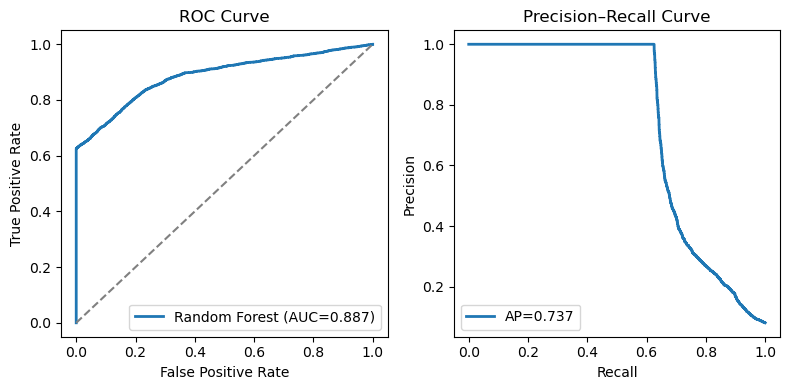

In [28]:
# Plotting primary metrics
from sklearn.metrics import roc_curve, precision_recall_curve

y_proba = predictions["Random Forest"]["proba"]
y_pred = predictions["Random Forest"]["pred"]

# Compute ROC curve, extract ROC_AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = df_results.loc[df_results["Model"] == "Random Forest", "ROC–AUC"].values[0]

# Compute PR curve, extract AP
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = df_results.loc[df_results["Model"] == "Random Forest", "PR–AUC"].values[0]

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# ROC panel
axes[0].plot(fpr, tpr, lw=2, label=f"Random Forest (AUC={roc_auc:.3f})")
axes[0].plot([0, 1], [0, 1], "--", color="gray")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend()

# PR panel
axes[1].plot(rec, prec, lw=2, label=f"AP={ap:.3f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision–Recall Curve")
axes[1].legend()

plt.tight_layout()
plt.draw()
save_fig(plt, "roc_pr_curves.png")

In [29]:
# checking the F1-optimal threshold (scan 0..1)
thr_grid = np.linspace(0, 1, 1001)
f1_vals = []
for t in thr_grid:
    y_pred = (y_proba >= t).astype(int)
    f1_vals.append(f1_score(y_test, y_pred))
t_f1 = float(thr_grid[int(np.argmax(f1_vals))])
print(f"F1-optimal threshold: {t_f1:.3f} (F1 = {max(f1_vals):.3f})")

F1-optimal threshold: 0.563 (F1 = 0.769)


Figure saved: /Users/emilyoor/Documents/Code/Portfolio_Project1_financialtransactions/Reports/figures/confusion_matrix_best.png


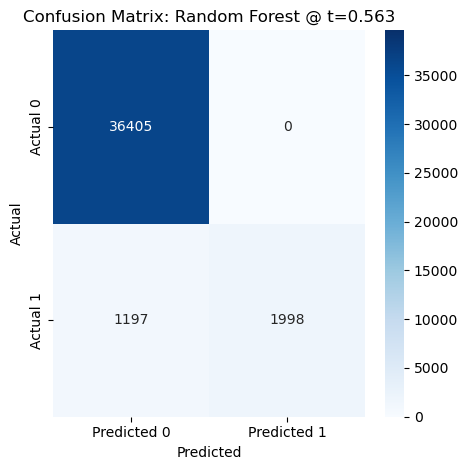

In [30]:
# Build confusion matrix with chosen threshold:
# pick your official operating point:
CHOSEN_T = t_f1  # main result
y_pred = (y_proba >= CHOSEN_T).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4.8, 4.8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
    vmin=0,
    vmax=np.sum(cm),
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix: Random Forest @ t={CHOSEN_T:.3f}")
plt.tight_layout()
plt.draw()
save_fig(plt, "confusion_matrix_best.png")

In [31]:
tn, fp, fn, tp = cm.ravel()
print(f"Confusion matrix @ t={CHOSEN_T:.3f}: TN {tn}, FP {fp}, FN {fn}, TP {tp}")

# Quick proportions
print(f"False positives: {fp} ({fp/(fp+tn):.2%} of legitimate transactions)")
print(f"False negatives: {fn} ({fn/(fn+tp):.2%} of fraud transactions)")

Confusion matrix @ t=0.563: TN 36405, FP 0, FN 1197, TP 1998
False positives: 0 (0.00% of legitimate transactions)
False negatives: 1197 (37.46% of fraud transactions)


In [32]:
# New RF metrics compared to old RF metrics

rf_f1opt = pd.DataFrame(
    [
        {
            "Model": "Random Forest (F1-optimal)",
            "ROC–AUC": round(roc_auc_score(y_test, y_proba), 3),
            "PR–AUC": round(average_precision_score(y_test, y_proba), 3),
            "Accuracy": round(accuracy_score(y_test, y_pred), 3),
            "Precision": precision_score(y_test, y_pred),
            "Recall": round(recall_score(y_test, y_pred), 3),
            "F1": round(f1_score(y_test, y_pred), 3),
            "Threshold": round(CHOSEN_T, 3),
        }
    ]
)

rf_summary["Threshold"] = 0.5  # add threshold column for consistency

# combine old and new
rf_compare = pd.concat([rf_summary, rf_f1opt], ignore_index=True)

print("\nRandom Forest comparison:\n", rf_compare.to_markdown(index=False))


Random Forest comparison:
 | Model                      |   ROC–AUC |   PR–AUC |   Accuracy |   Precision |   Recall |    F1 |   Threshold |
|:---------------------------|----------:|---------:|-----------:|------------:|---------:|------:|------------:|
| Random Forest              |     0.887 |    0.737 |      0.964 |       0.886 |    0.631 | 0.737 |       0.5   |
| Random Forest (F1-optimal) |     0.887 |    0.737 |      0.97  |       1     |    0.625 | 0.769 |       0.563 |


## 15) Error Analysis

False Negatives: 1197
True Positives: 1998
Figure saved: /Users/emilyoor/Documents/Code/Portfolio_Project1_financialtransactions/Reports/figures/error_analysis_tp_fn_3panel.png


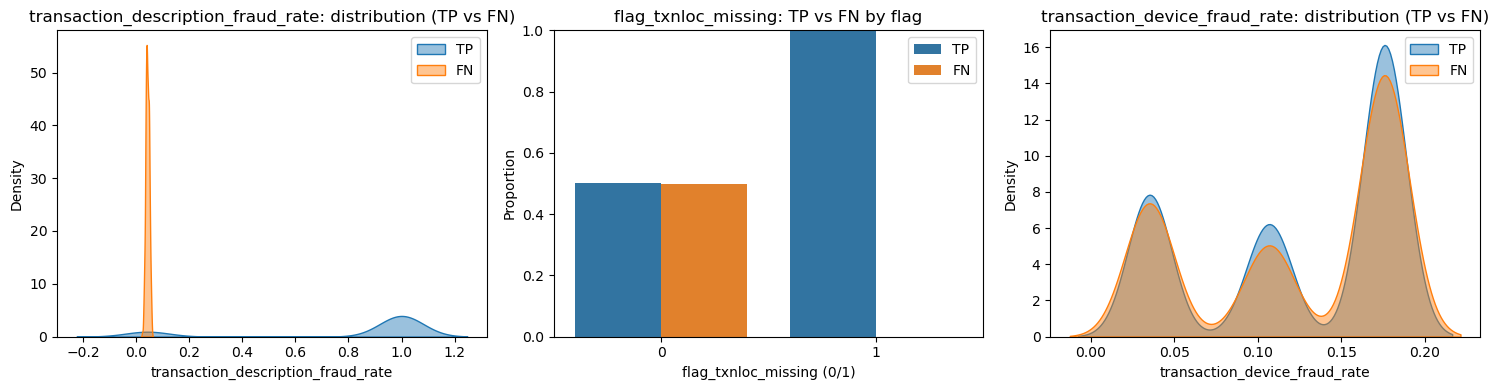

In [33]:
## --- Features to inspect ---
cols_to_plot = [
    "transaction_description_fraud_rate",
    "flag_txnloc_missing",
    "transaction_device_fraud_rate",
]

# Identify false negatives and true positives
fn_mask = (y_test == 1) & (y_pred == 0)
tp_mask = (y_test == 1) & (y_pred == 1)

fn = X_test.loc[fn_mask, cols_to_plot].copy()
tp = X_test.loc[tp_mask, cols_to_plot].copy()

print(f"False Negatives: {fn.shape[0]}")
print(f"True Positives: {tp.shape[0]}")

tp["label"] = "TP"
fn["label"] = "FN"
df_fraud = pd.concat([tp, fn], ignore_index=True)

# Plot
n = len(cols_to_plot)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), squeeze=False)

for i, col in enumerate(cols_to_plot):
    ax = axes[0, i]
    series = df_fraud[col].dropna()
    unique_vals = pd.unique(series)

    # binary check: only 0/1 present
    is_binary = set(np.unique(unique_vals)).issubset({0, 1})

    if is_binary:
        # proportions within each flag value: P(label | flag=v)
        counts = df_fraud.groupby([col, "label"]).size().reset_index(name="count")
        denom = counts.groupby(col)["count"].transform("sum")
        counts["prop"] = counts["count"] / denom
        counts[col] = counts[col].astype(int)

        sns.barplot(
            data=counts, x=col, y="prop", hue="label", ax=ax, hue_order=["TP", "FN"]
        )
        ax.set_ylim(0, 1)
        ax.set_xlabel(f"{col} (0/1)")
        ax.set_ylabel("Proportion")
        ax.set_title(f"{col}: TP vs FN by flag")
        ax.legend(title="")
    else:
        # KDEs for continuous features (TP vs FN)
        sns.kdeplot(
            data=df_fraud[df_fraud["label"] == "TP"][col].dropna(),
            label="TP",
            fill=True,
            alpha=0.45,
            common_norm=False,
            ax=ax,
        )
        sns.kdeplot(
            data=df_fraud[df_fraud["label"] == "FN"][col].dropna(),
            label="FN",
            fill=True,
            alpha=0.45,
            common_norm=False,
            ax=ax,
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Density")
        ax.set_title(f"{col}: distribution (TP vs FN)")
        ax.legend()

plt.tight_layout()
plt.draw()
save_fig(plt, "error_analysis_tp_fn_3panel.png")